In [1]:
import scipy.io
import scipy.interpolate
import numpy
import matlab.engine
eng = matlab.engine.start_matlab()

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LogLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import matplotlib.patches as patches
import os

# Color palette
### import seaborn as sns
#### sns.set()

# Axes font size
### sns.set(font_scale=1.25)
# sns.set(font_scale=1.1)

#sns.set_style("ticks")
#sns.despine()

#sns.set_palette("husl")
#sns.set_palette("PuBuGn_d")
#sns.set_palette("GnBu_d")
### sns.set_palette("OrRd_d")  #Good
# sns.set_palette("YlOrRd_d")  # Good
# sns.set_palette("autumn_d")   # Good
# sns.set_palette("hot_d")
# sns.set_palette("plasma_d")
#sns.palplot(sns.cubehelix_palette())
#sns.palplot(sns.color_palette("cubehelix", 8))

# LaTeX (two font options)
# Option 1: Use Baskervladx font
# matplotlib.rcParams['text.usetex'] = True
# plt.rc('text.latex',preamble=r' \usepackage{amsmath} \usepackage{xfrac} \usepackage{Baskervaldx} \usepackage[baskervaldx,bigdelims,vvarbb]{newtxmath}')
### matplotlib.rcParams['text.latex.unicode'] = True # do not use this line, deprecated
# Option 2: Use default LaTeX font (computer modern)
plt.rc('text',usetex=True)

matplotlib.font_manager._rebuild()

# Style sheet
# plt.style.use('ggplot')
# plt.style.use('seaborn-deep')
# plt.style.use('seaborn-colorblind')
### plt.style.use('seaborn-whitegrid')
# plt.style.use('Solarize_Light2')
#plt.style.use('bmh')

# Font (Note: this should be AFTER the plt.style.use)
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'  # text in svg file will be text not path.

#from cycler import cycler
#matplotlib.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

# Import basemap
try:
    from mpl_toolkits.basemap import Basemap
except:
    # The followings are needed to import Basemap. 
    # Recently importing Basemap gives an error (KeyError: 'PROJ_LIB').
    # The soluion is posted here: https://github.com/conda-forge/basemap-feedstock/issues/30#issuecomment-423512069
    import os
    import conda

    conda_file_dir = conda.__file__
    conda_dir = conda_file_dir.split('lib')[0]
    proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
    os.environ["PROJ_LIB"] = proj_lib

    # Now we import basemap
    from mpl_toolkits.basemap import Basemap

In [2]:
# Plot settings
# BaseDir = '/media/sia/LargeData/Data/ModalAnalysis/ABC-Flow/Cube-40/Reconstructed/custom/'
FiguresDir = '/home/sia/work/ADCP/ADCP-Stochastic/figures/'
# FigSize = (7,5)
SaveFormat = '.pdf'
#LineWidth = 1.5
#MarkerSize = 3

In [3]:
# Load config
ConfigFilename = '/home/sia/work/alpha/WhereIsMyPlume/python/Config.mat'
Config = eng.load(ConfigFilename)['Config']

# Load Data
DataFilename = '/home/sia/work/alpha/WhereIsMyPlume/python/Data.mat'
Data = eng.load(DataFilename)['Data']

# Load Output
OutputFilename = '/home/sia/work/alpha/WhereIsMyPlume/python/Output.mat'
Output = eng.load(OutputFilename)['Output']

# Load Drifters
Drifters = [None]*45
for i in range(1,46):
    DrifterFilename = '/home/sia/work/alpha/WhereIsMyPlume/python/Drifters'+str(i)+'.mat'
    Drifters[i-1] = eng.load(DrifterFilename)['Drifter'+str(i)]

In [4]:
# Load to numpy arrays
Range = numpy.squeeze(numpy.asarray(Data['Ocean']['Range']))      # in meters
DataTime = numpy.squeeze(numpy.asarray(Data['Time']))             # in seconds since 0000, 00, 00, 00:00:00
AbsoluteVel_u = numpy.asarray(Data['Ocean']['AbsoluteVel_u'])     # in meter per second
AbsoluteVel_v = numpy.asarray(Data['Ocean']['AbsoluteVel_v'])
AbsoluteVel_w = numpy.asarray(Data['Ocean']['AbsoluteVel_w'])

In [5]:
# Matlab times to python datetimes
from datetime import datetime,timedelta

def ConvertTimeToDatetime(TimeArrayInSeconds):
    # Convert seconds to days
    TimeArrayAsDay = TimeArrayInSeconds / (24*3600)

    # Convert days to datetime object
    DatetimeList = [None] * TimeArrayAsDay.size
    for i in range(TimeArrayAsDay.size):
        DatetimeList[i] = datetime.fromordinal(TimeArrayAsDay[i].astype(int)) \
                    + timedelta(days=TimeArrayAsDay[i]%1) \
                    - timedelta(days = 366)
    
    # Lsit of numpy array
    Datetime = numpy.array(DatetimeList)
    return Datetime

# ----------
DataDatetime = ConvertTimeToDatetime(DataTime)

In [6]:
MaxBathymetryIndex = numpy.argwhere(numpy.all(numpy.isnan(AbsoluteVel_u),axis=1))[0][0] + 2

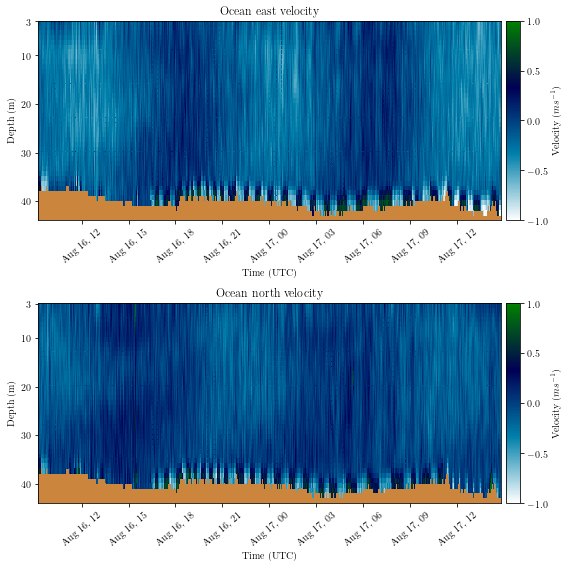

In [7]:
fig,ax = plt.subplots(2,1,figsize=(8,8))
#fig,ax = plt.subplots(2,1,figsize=(8,8))

# East Velocity
draw0 = ax[0].pcolormesh(DataDatetime,Range[0:MaxBathymetryIndex],AbsoluteVel_u[0:MaxBathymetryIndex,:], \
                 shading='bicubic',cmap=plt.cm.ocean_r,rasterized=True,vmin=-1,vmax=1)

#draw0 = ax[0].pcolormesh(Datetime,R[0:MaxBathymetryIndex*N],u[0:MaxBathymetryIndex*N,:], \
#                 shading='bicubic',cmap=plt.cm.ocean_r,rasterized=True,vmin=-1,vmax=1)

ax[0].set_yticks(numpy.append([3],numpy.arange(10,50,10)))
ax[0].invert_yaxis()
ax[0].tick_params(axis='x',rotation=40)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H'))
ax[0].set_aspect('auto')
ax[0].set_facecolor([0.8,0.52,0.24])
ax[0].set_xlabel('Time (UTC)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Ocean east velocity')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right",size="3%",pad=0.07)
cb0 = plt.colorbar(draw0,cax=cax0,ticks=[-1,-0.5,0,0.5,1])
cb0.solids.set_rasterized(True)
cb0.set_label('Velocity ($m s^{-1}$)')

# North Velocity
draw1 = ax[1].pcolormesh(DataDatetime,Range[0:MaxBathymetryIndex],AbsoluteVel_v[0:MaxBathymetryIndex,:], \
                 shading='bicubic',cmap=plt.cm.ocean_r,rasterized=True,vmin=-1,vmax=1)
ax[1].set_yticks(numpy.append([3],numpy.arange(10,50,10)))
ax[1].invert_yaxis()
ax[1].tick_params(axis='x',rotation=40)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H'))
ax[1].set_aspect('auto')
ax[1].set_facecolor([0.8,0.52,0.24])
ax[1].set_xlabel('Time (UTC)')
ax[1].set_ylabel('Depth (m)')
ax[1].set_title('Ocean north velocity')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right",size="3%",pad=0.07)
cb1 = plt.colorbar(draw1,cax=cax1,ticks=[-1,-0.5,0,0.5,1])
cb1.solids.set_rasterized(True)
cb1.set_label('Velocity ($ms^{-1}$)')

plt.tight_layout()
plt.savefig(FiguresDir+'OceanVelocity'+SaveFormat,bbox_inches='tight',dpi=400,facecolor=[0,0,0,0])
plt.show()

In [8]:
# Ship
ShipLon = numpy.squeeze(numpy.asarray(Data['Ship']['Longitude']))
ShipLat = numpy.squeeze(numpy.asarray(Data['Ship']['Latitude']))

# Ship trajectory
ShipTrajectoryLon = numpy.squeeze(numpy.asarray(Output['ShipTrajectory']['Longitude']))
ShipTrajectoryLat = numpy.squeeze(numpy.asarray(Output['ShipTrajectory']['Latitude']))

# Central trajectory
CenterTrajectoryLon = numpy.squeeze(numpy.asarray(Output['PlumeCenterTrajectory']['Longitudes']))
CenterTrajectoryLat = numpy.squeeze(numpy.asarray(Output['PlumeCenterTrajectory']['Latitudes']))
CenterTrajectoryTime = numpy.squeeze(numpy.asarray(Output['PlumeCenterTrajectory']['Times']))
CenterTrajectoryFirstLon = numpy.asarray(Output['PlumeCenterTrajectory']['FirstLongitude'])
CenterTrajectoryFirstLat = numpy.asarray(Output['PlumeCenterTrajectory']['FirstLatitude'])
CenterTrajectoryLastLon = numpy.asarray(Output['PlumeCenterTrajectory']['LastLongitude'])
CenterTrajectoryLastLat = numpy.asarray(Output['PlumeCenterTrajectory']['LastLatitude'])

# Stochastic trajectories
if 'StochasticPlumeCenterTrajectories' in Output.keys():
    StochasticTrajectoriesLon = numpy.asarray(Output['StochasticPlumeCenterTrajectories']['Longitudes'])
    StochasticTrajectoriesLat = numpy.asarray(Output['StochasticPlumeCenterTrajectories']['Latitudes'])
    StochasticTrajectoriesTime = numpy.asarray(Output['StochasticPlumeCenterTrajectories']['Times'])
    
# Stochastic PDF
if 'StochasticPDF' in Output.keys():
    StochasticPDF_Values = numpy.asarray(Output['StochasticPDF']['PDF_ValuesOnGrid'])
    StochasticCCDF_Values = numpy.asarray(Output['StochasticPDF']['CCDF_ValuesOnGrid'])
    StochasticPDF_GridLon = numpy.asarray(Output['StochasticPDF']['LongitudeGrid'])
    StochasticPDF_GridLat = numpy.asarray(Output['StochasticPDF']['LatitudeGrid'])
    
# Convert trajectory times as seconds to dates
CenterTrajectoryDatetime = ConvertTimeToDatetime(CenterTrajectoryTime)

In [9]:
# ------------------------
# Get Transparent Colormap
# ------------------------

def GetTransparentColormap(ColorMap):
    """
    Converts a colormap to a transparent colormap, where the lower range
    is transparent (alpha=0) and upper range is full color (alpha=1)
    """
    
    def Ramp(N,StartTransition,EndTransition):
        """
        N: Size of output array.
        TurnPoint: Number between 0 and 1.
        output is also in [0,1]. 0 means transparent, 1 means non-transparent.
        
        From [0,TurnPoint], y linearly increase from 0 to 1
        From [TurnPoint,1], y is 1.
        """

        StartTransitionIndex = int(N*StartTransition)
        EndTransitionIndex = int(N*EndTransition)
        y = numpy.ones((N,),dtype=float)
        y[:StartTransitionIndex] = 0
        y[StartTransitionIndex:EndTransitionIndex] = numpy.linspace(0,1,EndTransitionIndex-StartTransitionIndex)
        y[EndTransitionIndex:] = 1

        return y

    # ---------------------

    TransparentColorMap = ColorMap(numpy.arange(ColorMap.N))
    x = numpy.linspace(0,1,ColorMap.N)
    # TransparentColorMap[:,-1] = x                                               # Linear. More transparent at lower bound of data range
    # TransparentColorMap[:,-1] = 1.0 - (x - 1.0)**10                              # Quadratic
    # TransparentColorMap[:,-1] = x**3 - 3.0*x**2 + 3*x                           # Cubic
    # TransparentColorMap[:,-1] = 1.0 - (x - 1.0)**4                                # 4th order polynomial
    # TransparentColorMap[:,-1] = 1.0 - (x)**4                                    # 4th order polynomial
    # TransparentColorMap[:,-1] = 2.0*x**3-3.0*x**2+1.0
    
    # TransparentColorMap[:,-1] = Ramp(ColorMap.N,0.00005,0.2)
    #TransparentColorMap[:,-1] = Ramp(ColorMap.N,0.00000001,0.1)
    
    TransparentColorMap[int(ColorMap.N*0.905):,:3] = 1
    TransparentColorMap[:,-1] = 1-Ramp(ColorMap.N,0.85,0.905)
    

    # x = numpy.ones((ColorMap.N,))
    # x[int(ColorMap.N*0.98):] = 0
    # TransparentColorMap[:,-1] = x

    # TransparentColorMap[:,-1] = x[::-1]                                         # More transparent at upper bound of data range
    # TransparentColorMap[:,-1] = numpy.fabs(numpy.linspace(-1,1,ColorMap.N))     # More transparent at center of data range
    TransparentColorMap = ListedColormap(TransparentColorMap)

    return TransparentColorMap

In [10]:
# ColorMap = plt.cm.Reds
# ColorMap = plt.cm.magma
# ColorMap = plt.cm.inferno_r
# ColorMap = plt.cm.gnuplot2_r
# ColorMap = plt.cm.gist_heat_r
# ColorMap = plt.cm.jet
# ColorMap = plt.cm.nipy_spectral
# ColorMap = plt.get_cmap('nipy_spectral',5000)
# ColorMap = plt.get_cmap('magma_r',5000)
# Colors = plt.cm.nipy_spectral(numpy.linspace(0.05,0.95,20000))
# ColorMap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap',Colors)
##ColorMap = plt.get_cmap('nipy_spectral_r',1000000)
# colors = ColorMap(numpy.linspace(0.04,1,256))
# ColorMap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap',colors)
##ColorMap = GetTransparentColormap(ColorMap)

Colors = plt.cm.nipy_spectral_r(numpy.linspace(0.05,1,2000))
ColorMap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap',Colors)

ColorMap = GetTransparentColormap(ColorMap)

In [11]:
# Map's scale ruler
class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

In [12]:
# Kilometer to Lon degrees
def LengthToAngle(Length,MeanLatitude):
    # Length is in Kilometers
    # Mean laltitude in degrees
    # Output: Angle (in degrees)
    EarthRadius = 6371.0088 # Km
    EarthRadiusInLatitude = EarthRadius * numpy.cos(MeanLatitude*numpy.pi/180.0)
    Angle = (Length / EarthRadiusInLatitude)*180.0/numpy.pi
    return Angle

In [13]:
# Drifters
DayToSecond = 24.0 * 3600.0;
h_drift = [];
Counter = 1;
DriftersToPlot = numpy.asarray(Config['Plots']['DriftersToPlot']).astype(int)

DriftersToPlot_Lon = []
DriftersToPlot_Lat = []
DriftersToPlot_Id = []

for i in range(len(Drifters)):

    # Filter Drifters (empty DriftersToPlot will plot all)
    if numpy.isnan(Drifters[i]['Id']):
        continue
    if numpy.all(int(Drifters[i]['Id']) != DriftersToPlot):
        continue
    
    # If non of the two above conditions met, we found the drifter Id
    DrifterId = int(Drifters[i]['Id'])
        
    DrifterTime = numpy.squeeze(numpy.asarray(Drifters[i]['Time'])) * DayToSecond
    UniqueDrifterTime,Index = numpy.unique(DrifterTime,return_index=True)   # Remove duplicates
    if (DrifterTime[0] <= DataTime[0]) and (DrifterTime[-1] >= DataTime[-1]):
        print('Reading drifter: %d\n'%DrifterId)

        # Get Drifter info
        DrifterLongitude = numpy.squeeze(numpy.asarray(Drifters[i]['Longitude']))
        DrifterLatitude = numpy.squeeze(numpy.asarray(Drifters[i]['Latitude']))
        
        # Rearrange indices for unique time indices
        DrifterLongitude = DrifterLongitude[Index]
        DrifterLatitude = DrifterLatitude[Index]
        
        # Remove nan values from lon and lat so that they can be used with scipy.interpolate
        NanLon = numpy.isnan(DrifterLongitude)
        NanLat = numpy.isnan(DrifterLatitude)
        
        NanIndices = NanLon & NanLat
        NotNanIndices = numpy.logical_not(NanIndices)
        
        DrifterLongitude = DrifterLongitude[NotNanIndices]
        DrifterLatitude = DrifterLatitude[NotNanIndices]
        UniqueDrifterTime = UniqueDrifterTime[NotNanIndices]

        # Interpolate lat and lon to Data.Time
        Longitude = scipy.interpolate.pchip_interpolate(UniqueDrifterTime,DrifterLongitude,CenterTrajectoryTime)
        Latitude = scipy.interpolate.pchip_interpolate(UniqueDrifterTime,DrifterLatitude,CenterTrajectoryTime)
        
        # Store
        DriftersToPlot_Lon.append(Longitude)
        DriftersToPlot_Lat.append(Latitude)
        DriftersToPlot_Id.append(DrifterId)

Reading drifter: 24

Reading drifter: 25

Reading drifter: 28

Reading drifter: 31

Reading drifter: 32

Reading drifter: 33

Reading drifter: 34

Reading drifter: 35

Reading drifter: 36

Reading drifter: 37

Reading drifter: 38

Reading drifter: 39

Reading drifter: 40

Reading drifter: 41

Reading drifter: 42

Reading drifter: 43



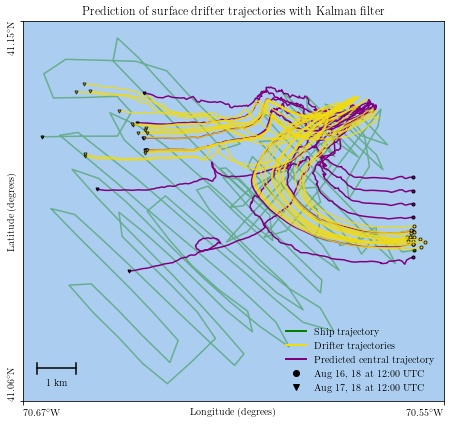

In [14]:
fig2,ax2 = plt.subplots(figsize=(8,6))


# Plots
# h1=ax2.plot(ShipLon,ShipLat,':',color='green',alpha=0.5)
h2=ax2.plot(ShipTrajectoryLon,ShipTrajectoryLat,color='green',Markeredgecolor='black',label='Ship',alpha=0.4)
h3=ax2.plot(CenterTrajectoryLon,CenterTrajectoryLat,color='purple',Markeredgecolor='black',label='Central trajectory',zorder=2)

if 'StochasticPlumeCenterTrajectories' in Output.keys():
    h4=ax2.plot(StochasticTrajectoriesLon,StochasticTrajectoriesLat,color='pink', \
                alpha=0.3,label='Stochastic trajectories',zorder=-1)

if 'StochasticPDF' in Output.keys():  
    CDF = 1-StochasticCCDF_Values
    MinCDF = 0
    MaxCDF = 1
    h5=ax2.pcolormesh(StochasticPDF_GridLon,StochasticPDF_GridLat,CDF,label='CCDF', \
                 cmap=ColorMap,antialiased=True,rasterized=True,vmin=MinCDF,vmax=MaxCDF)

# Start and end location
ax2.plot(ShipTrajectoryLon[0],ShipTrajectoryLat[0],'o',color='green',Markeredgecolor='black',Markersize=3)
ax2.plot(ShipTrajectoryLon[-1],ShipTrajectoryLat[-1],'v',color='green',Markeredgecolor='black',Markersize=3)
ax2.plot(CenterTrajectoryLon[0,:],CenterTrajectoryLat[0,:],'o',color='purple',Markeredgecolor='black',Markersize=3,zorder=2)
ax2.plot(CenterTrajectoryLon[-1,:],CenterTrajectoryLat[-1,:],'v',color='purple',Markeredgecolor='black',Markersize=3,zorder=2)

# Times texts
#ax2.text(CenterTrajectoryFirstLon,CenterTrajectoryFirstLat-0.003, \
#         CenterTrajectoryDatetime[0].strftime("%b %d\n%H:%M"),fontsize=10,ha='center',va='top')
#ax2.text(CenterTrajectoryLastLon,CenterTrajectoryLastLat+0.0055,\
#         CenterTrajectoryDatetime[-1].strftime("%b %d\n%H:%M"),fontsize=10,ha='center',va='top')

# Drifters
# DrifterColor = [0.45,0.45,0.45];
DrifterColor = numpy.array([235, 107, 52])/255.0
DrifterColor = numpy.array([242, 219, 15])/255.0
DrifterAlpha = 0.8
for i in range(len(DriftersToPlot_Lon)):
    h6 = ax2.plot(DriftersToPlot_Lon[i],DriftersToPlot_Lat[i],color=DrifterColor, \
             label='Drifter '+str(DrifterId),alpha=DrifterAlpha,zorder=3)
    ax2.plot(DriftersToPlot_Lon[i][0],DriftersToPlot_Lat[i][0],'o',color=DrifterColor, \
             Markersize=3,Markeredgecolor='black',alpha=DrifterAlpha,zorder=3)
    ax2.plot(DriftersToPlot_Lon[i][-1],DriftersToPlot_Lat[i][-1],'v',color=DrifterColor, \
             Markersize=3,Markeredgecolor='black',alpha=DrifterAlpha,zorder=3)

# Axes
ax2.set_facecolor('#abcdef')
# ax2.set_title('Stochastic prediction of subsurface (15m) drifter trajectories')
ax2.set_title('Prediction of surface drifter trajectories with Kalman filter')
ax2.set_xlabel('Longitude (degrees)',labelpad=-10)
ax2.set_ylabel('Latitude (degrees)',labelpad=-10)
ax2.set_aspect(1.0/numpy.cos(numpy.mean(ShipLat)*numpy.pi/180.0))

# Scale ruler
MeanLatitude = numpy.mean(ShipLat)
ob = AnchoredHScaleBar(size=LengthToAngle(1,MeanLatitude),label="1 km", \
                       loc=3,frameon=False,pad=0.9,sep=4,linekw=dict(color="black"))
ax2.add_artist(ob)

# X labels
ax2.set_xticks(ax2.get_xlim())
ax2.set_xticklabels([r'$%0.2f^{\circ}$W'%y for y in numpy.abs(ax2.get_xlim())])
ax2.get_xticklabels()[0].set_ha('left')
ax2.get_xticklabels()[1].set_ha('right')

# Y labels
ax2.set_yticks(ax2.get_ylim())
ax2.set_yticklabels([r'$%0.2f^{\circ}$N'%y for y in ax2.get_ylim()],rotation=90)
ax2.get_yticklabels()[0].set_va('bottom')
ax2.get_yticklabels()[1].set_va('top')

# Legends
CustomLines = [Line2D([0],[0],lw=2,color=h2[0].get_color()), \
               Line2D([0],[0],lw=2,color=h6[0].get_color()), \
               Line2D([0],[0],lw=2,color=h3[0].get_color())]
LegendNames = ['Ship trajectory','Drifter trajectories','Predicted central trajectory']

if 'StochasticPlumeCenterTrajectories' in Output.keys():
    CustomLines.append(Line2D([0],[0],lw=2,color=h4[0].get_color()))
    LegendNames.append('Stochastic trajectories')
    
# Add timestamps to the legend
CustomLines.append(Line2D(range(1),range(1),linewidth=0,color="black",marker="o",markerfacecolor="black"))
CustomLines.append(Line2D(range(1),range(1),linewidth=0,color="black",marker="v",markerfacecolor="black"))
LegendNames.append(CenterTrajectoryDatetime[0].strftime("%b %d, %y at %H:%M UTC"))
LegendNames.append(CenterTrajectoryDatetime[-1].strftime("%b %d, %y at %H:%M UTC"))
    
ax2.legend(CustomLines,LegendNames,frameon=False,framealpha=0,fontsize=10)

# Colorbar
if 'StochasticPDF' in Output.keys():   
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right",size="2%",pad=-0.9)
    #cax = divider.append_axes("right",size="2%")
    sm = plt.cm.ScalarMappable(cmap=ColorMap,norm=matplotlib.colors.Normalize(vmin=MinCDF,vmax=MaxCDF))
    # sm = plt.cm.ScalarMappable(cmap=ColorMap)
    sm._A = []
    cb = plt.colorbar(sm,cax=cax)
    cb.set_alpha(1)
    cb.set_label('Cumulative Distribution Function (percent)')
    cb.solids.set_rasterized(True)
    ColorTicks = numpy.arange(0,MaxCDF+0.01,0.1)
    cb.set_ticks(ColorTicks)
    cb.set_ticklabels([r'$%d\%%$'%y for y in numpy.arange(0,101,10)])
    cb.draw_all()

plt.tight_layout()
plt.savefig(FiguresDir+'Trajectories'+SaveFormat,bbox_inches='tight',dpi=400,facecolor=[0,0,0,0])
plt.show()